# Рахуємо LTV і CAC

In [1]:
import pandas as pd 
from termcolor import cprint
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [83]:
orders = pd.read_csv('./data/ltv_orders_2.csv')
costs = pd.read_csv('./data/ltv_costs_2.csv')

cprint('______________orders________________', 'green')
print()
cprint(orders.head(),'green')
print()
cprint('______________costs________________', 'blue')
print()
cprint(costs.head(), 'blue')

______________orders________________

               oid  order_date  revenue            uid
0  o_6464340367720  2019-06-04      987  1977063117428
1  o_3250639350268  2019-07-09     1757  1977063117428
2  o_1069773391530  2019-07-21     1380  1977063117428
3  o_8535010565482  2019-08-11     1150  1977063117428
4  o_0501192807113  2019-04-12     1117  1411482247934

______________costs________________

         date  costs
0  2019-01-07   3085
1  2019-01-12   5594
2  2019-01-13   8523
3  2019-01-14  10356
4  2019-01-15   7455


Дивимось розподіл дат замовлень

In [3]:
cprint('______________orders________________', 'green')
print(orders['order_date'].describe())
print(orders['order_date'].min())
print(orders['order_date'].max())
cprint('______________costs________________', 'blue')
print(costs['date'].describe())
print(costs['date'].min())
print(costs['date'].max())

______________orders________________
count           5946
unique           240
top       2019-06-27
freq              53
Name: order_date, dtype: object
2019-01-07
2019-09-08
______________costs________________
count            236
unique           236
top       2019-01-07
freq               1
Name: date, dtype: object
2019-01-07
2019-09-08


У нас дані по виручці та витратам за однаковий період в 8 місяців. 

Подивимось динаміку виручки та затрат по кожному місяцю. 

In [4]:
orders['order_month'] = pd.to_datetime(orders['order_date']).dt.to_period('M')
revenue_per_month = orders.groupby('order_month').agg({'revenue': 'sum'})
revenue_per_month

,revenue
order_month,
2019-01,61650
2019-02,223917
2019-03,497242
2019-04,687080
2019-05,894742
2019-06,1050544
2019-07,1109351
2019-08,1141694
2019-09,266026


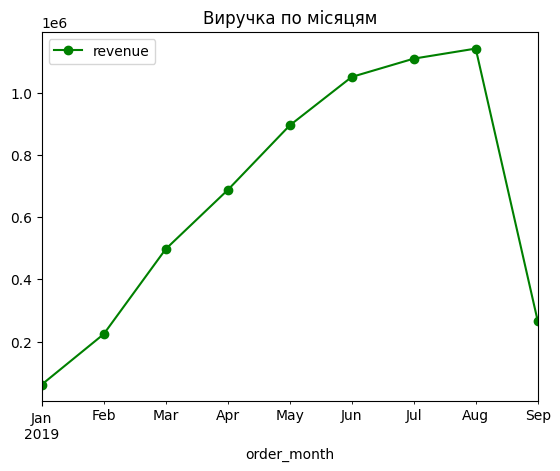

In [5]:
orders.groupby('order_month').agg({'revenue': 'sum'}).plot(kind='line', marker = 'o', title='Виручка по місяцям', color='g');

In [6]:
costs['cost_month'] = pd.to_datetime(costs['date']).dt.to_period('M')
cost_per_month = costs.groupby('cost_month').agg({'costs': 'sum'})
cost_per_month 

,costs
cost_month,
2019-01,131376
2019-02,365652
2019-03,574721
2019-04,496602
2019-05,536254
2019-06,660975
2019-07,706049
2019-08,796449
2019-09,207446


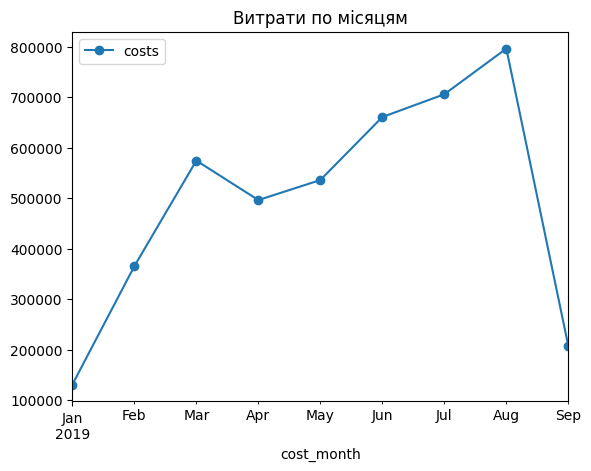

In [7]:
costs.groupby('cost_month').agg({'costs': 'sum'}).plot(kind='line',marker = 'o',title='Витрати по місяцям' );

In [8]:
revenue_per_month.join(cost_per_month)

,revenue,costs
order_month,,
2019-01,61650,131376
2019-02,223917,365652
2019-03,497242,574721
2019-04,687080,496602
2019-05,894742,536254
2019-06,1050544,660975
2019-07,1109351,706049
2019-08,1141694,796449
2019-09,266026,207446


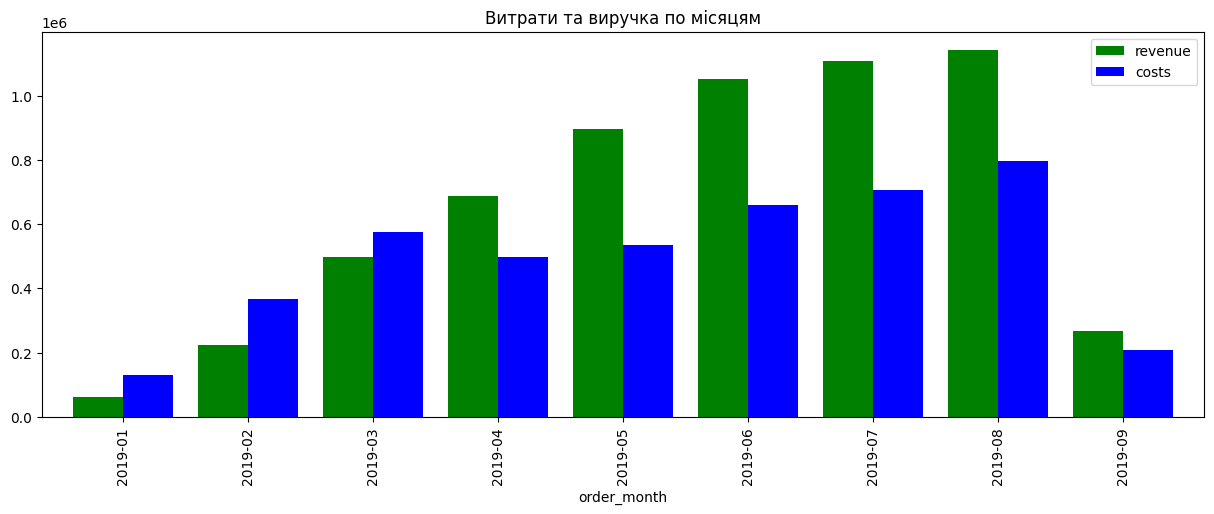

In [9]:
revenue_per_month.join(cost_per_month, how='outer').plot(kind='bar', title='Витрати та виручка по місяцям', color=['g','b'], figsize=(15, 5), width=0.8);

Виручка почала перевищувати витрати лише з 4-го місяця. 

Розрахуємо LTV
для цього розіб'ємо замовлення по когортам по даті першого замовлення. 

In [10]:
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']
first_orders.head()

,uid,first_order_month
0,13074317240,2019-08
1,13358924638,2019-03
2,14050647580,2019-03
3,16884559282,2019-06
4,20218465033,2019-05


Подивимось на кількість клієнтів в кожній когорті. 

In [11]:
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes

,first_order_month,n_buyers
0,2019-01,46
1,2019-02,122
2,2019-03,182
3,2019-04,173
4,2019-05,182
5,2019-06,220
6,2019-07,233
7,2019-08,268
8,2019-09,67


Добавимо в таблицю з замовленнями стовчик з місяцем першого замовлення.

In [12]:
orders = orders.merge(first_orders, on='uid')
orders.head()

,oid,order_date,revenue,uid,order_month,first_order_month
0,o_6464340367720,2019-06-04,987,1977063117428,2019-06,2019-06
1,o_3250639350268,2019-07-09,1757,1977063117428,2019-07,2019-06
2,o_1069773391530,2019-07-21,1380,1977063117428,2019-07,2019-06
3,o_8535010565482,2019-08-11,1150,1977063117428,2019-08,2019-06
4,o_0501192807113,2019-04-12,1117,1411482247934,2019-04,2019-04


Дізнаємось скільки коштів нам принесла кожна когорта по місяцях. 

In [13]:
orders.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'})

revenue
first_order_month order_month         
2019-01           2019-01        61650
                  2019-02        55981
                  2019-03        65240
                  2019-04        55709
                  2019-05        37410
                  2019-06         8085
                  2019-07          574
2019-02           2019-02       167936
                  2019-03       147532
                  2019-04       159665
                  2019-05       134672
                  2019-06        78726
                  2019-07        26715
                  2019-08         5200
2019-03           2019-03       284470
                  2019-04       224435
                  2019-05       249935
                  2019-06       193514
                  2019-07       112227
                  2019-08        40590
                  2019-09         1878
2019-04           2019-04       247271
                  2019-05       227879
                  2019-06       197366
                  2019-07       180719
                  2019-08        85953
                  2019-09         8609
2019-05           2019-05       244846
                  2019-06       230581
                  2019-07       204709
                  2019-08       118118
                  2019-09        14193
2019-06           2019-06       342272
                  2019-07       272781
                  2019-08       203678
                  2019-09        29303
2019-07           2019-07       311626
                  2019-08       299428
                  2019-09        70505
2019-08           2019-08       388727
                  2019-09        77670
2019-09           2019-09        63868

Скинемо індески і добавимо ще колонку з розміром когорти. 

In [14]:
cohort_sizes

,first_order_month,n_buyers
0,2019-01,46
1,2019-02,122
2,2019-03,182
3,2019-04,173
4,2019-05,182
5,2019-06,220
6,2019-07,233
7,2019-08,268
8,2019-09,67


In [15]:
cohorts = orders.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
cohorts = cohorts.merge(cohort_sizes, on='first_order_month')
cohorts.tail(5)



,first_order_month,order_month,revenue,n_buyers
37,2019-07,2019-08,299428,233
38,2019-07,2019-09,70505,233
39,2019-08,2019-08,388727,268
40,2019-08,2019-09,77670,268
41,2019-09,2019-09,63868,67


Вирахуємо кількість місяців від першої покупки для кожної когорти. 

In [16]:
cohorts['age'] = (cohorts['order_month'] - cohorts['first_order_month']).apply(lambda x: x.n)
cohorts.head(12)

,first_order_month,order_month,revenue,n_buyers,age
0,2019-01,2019-01,61650,46,0
1,2019-01,2019-02,55981,46,1
2,2019-01,2019-03,65240,46,2
3,2019-01,2019-04,55709,46,3
4,2019-01,2019-05,37410,46,4
5,2019-01,2019-06,8085,46,5
6,2019-01,2019-07,574,46,6
7,2019-02,2019-02,167936,122,0
8,2019-02,2019-03,147532,122,1
9,2019-02,2019-04,159665,122,2


Добавимо змінну маржинальності, і порахуємо LTV по прибутку з кожної когорти на кожного клієнта. 

In [17]:
margin  = 0.4

cohorts['gp'] = cohorts['revenue'] * margin 
cohorts.head()

,first_order_month,order_month,revenue,n_buyers,age,gp
0,2019-01,2019-01,61650,46,0,24660.0
1,2019-01,2019-02,55981,46,1,22392.4
2,2019-01,2019-03,65240,46,2,26096.0
3,2019-01,2019-04,55709,46,3,22283.6
4,2019-01,2019-05,37410,46,4,14964.0


In [18]:
cohorts['ltv'] = cohorts['gp']/cohorts['n_buyers'] 
cohorts.head(12)

,first_order_month,order_month,revenue,n_buyers,age,gp,ltv
0,2019-01,2019-01,61650,46,0,24660.0,536.086957
1,2019-01,2019-02,55981,46,1,22392.4,486.791304
2,2019-01,2019-03,65240,46,2,26096.0,567.304348
3,2019-01,2019-04,55709,46,3,22283.6,484.426087
4,2019-01,2019-05,37410,46,4,14964.0,325.304348
5,2019-01,2019-06,8085,46,5,3234.0,70.304348
6,2019-01,2019-07,574,46,6,229.6,4.991304
7,2019-02,2019-02,167936,122,0,67174.4,550.609836
8,2019-02,2019-03,147532,122,1,59012.8,483.711475
9,2019-02,2019-04,159665,122,2,63866.0,523.491803


Зробимо стандартну таблицю для когорт.

In [38]:
cohorts_pivot = cohorts.pivot_table(
    index='first_order_month', columns='age',values='ltv', aggfunc='mean'
    ).round(2)
cohorts_pivot.fillna('')

age,0,1,2,3,4,5,6
first_order_month,,,,,,,
2019-01,536.09,486.79,567.3,484.43,325.3,70.3,4.99
2019-02,550.61,483.71,523.49,441.55,258.12,87.59,17.05
2019-03,625.21,493.26,549.31,425.31,246.65,89.21,4.13
2019-04,571.72,526.89,456.34,417.85,198.74,19.91,
2019-05,538.12,506.77,449.91,259.6,31.19,,
2019-06,622.31,495.97,370.32,53.28,,,
2019-07,534.98,514.04,121.04,,,,
2019-08,580.19,115.93,,,,,
2019-09,381.30,,,,,,


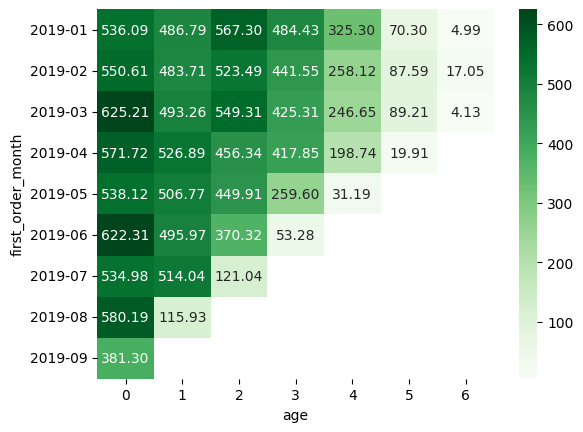

In [39]:

sns.heatmap(cohorts_pivot, cmap='Greens', annot=True, fmt='.2f');

Видно, що максимальний час оплати за наш продукт 7 місяців. Останні когорти менш активно купують на наступні місяці ніж перші когорти. Можливо інші канали залучення клієнтів були. Треба буде уточнити у маркетологів. 

Треба розрахувати ще ціну залучення клієнта CAC.
Для цього добавимо до нашої таблиці дані з витратами. 

In [40]:
costs.head()

,date,costs,cost_month
0,2019-01-07,3085,2019-01
1,2019-01-12,5594,2019-01
2,2019-01-13,8523,2019-01
3,2019-01-14,10356,2019-01
4,2019-01-15,7455,2019-01


In [41]:
mountly_costs = costs.groupby('cost_month').agg({'costs':'sum'}).reset_index()
mountly_costs

,cost_month,costs
0,2019-01,131376
1,2019-02,365652
2,2019-03,574721
3,2019-04,496602
4,2019-05,536254
5,2019-06,660975
6,2019-07,706049
7,2019-08,796449
8,2019-09,207446


In [42]:
cohorts = cohorts.merge(mountly_costs, left_on='first_order_month', right_on='cost_month', how='left')

cohorts.head(10)

,first_order_month,order_month,revenue,n_buyers,age,gp,ltv,cost_month,costs
0,2019-01,2019-01,61650,46,0,24660.0,536.086957,2019-01,131376
1,2019-01,2019-02,55981,46,1,22392.4,486.791304,2019-01,131376
2,2019-01,2019-03,65240,46,2,26096.0,567.304348,2019-01,131376
3,2019-01,2019-04,55709,46,3,22283.6,484.426087,2019-01,131376
4,2019-01,2019-05,37410,46,4,14964.0,325.304348,2019-01,131376
5,2019-01,2019-06,8085,46,5,3234.0,70.304348,2019-01,131376
6,2019-01,2019-07,574,46,6,229.6,4.991304,2019-01,131376
7,2019-02,2019-02,167936,122,0,67174.4,550.609836,2019-02,365652
8,2019-02,2019-03,147532,122,1,59012.8,483.711475,2019-02,365652
9,2019-02,2019-04,159665,122,2,63866.0,523.491803,2019-02,365652


Розрахуємо ціну залучення одного клієнта

In [44]:
cohorts['cac'] = cohorts['costs'] / cohorts['n_buyers']
cohorts.head(10)

,first_order_month,order_month,revenue,n_buyers,age,gp,ltv,cost_month,costs,cac
0,2019-01,2019-01,61650,46,0,24660.0,536.086957,2019-01,131376,2856.000000
1,2019-01,2019-02,55981,46,1,22392.4,486.791304,2019-01,131376,2856.000000
2,2019-01,2019-03,65240,46,2,26096.0,567.304348,2019-01,131376,2856.000000
3,2019-01,2019-04,55709,46,3,22283.6,484.426087,2019-01,131376,2856.000000
4,2019-01,2019-05,37410,46,4,14964.0,325.304348,2019-01,131376,2856.000000
5,2019-01,2019-06,8085,46,5,3234.0,70.304348,2019-01,131376,2856.000000
6,2019-01,2019-07,574,46,6,229.6,4.991304,2019-01,131376,2856.000000
7,2019-02,2019-02,167936,122,0,67174.4,550.609836,2019-02,365652,2997.147541
8,2019-02,2019-03,147532,122,1,59012.8,483.711475,2019-02,365652,2997.147541
9,2019-02,2019-04,159665,122,2,63866.0,523.491803,2019-02,365652,2997.147541


Розрахуємо окупаємість інвестицій в рекламу ROMI

In [45]:
cohorts['romi'] = cohorts['ltv']/cohorts['cac']
cohorts.head()

,first_order_month,order_month,revenue,n_buyers,age,gp,ltv,cost_month,costs,cac,romi
0,2019-01,2019-01,61650,46,0,24660.0,536.086957,2019-01,131376,2856.0,0.187706
1,2019-01,2019-02,55981,46,1,22392.4,486.791304,2019-01,131376,2856.0,0.170445
2,2019-01,2019-03,65240,46,2,26096.0,567.304348,2019-01,131376,2856.0,0.198636
3,2019-01,2019-04,55709,46,3,22283.6,484.426087,2019-01,131376,2856.0,0.169617
4,2019-01,2019-05,37410,46,4,14964.0,325.304348,2019-01,131376,2856.0,0.113902


In [47]:
cohorts[cohorts['age'] == 0]['romi']

0     0.187706
7     0.183711
14    0.197988
21    0.199170
27    0.182634
32    0.207132
36    0.176546
39    0.195230
41    0.123151
Name: romi, dtype: float64

Бачимо, що ROMI нульового місяця у нас не більше 20%.
Потрібно дізнатися на який місяць в нас почнуть окупатися клієнти. 

In [52]:
romi_report = cohorts.pivot_table(
    index='first_order_month', columns= 'age', values= 'romi', aggfunc='mean'
).cumsum(axis=1).round(2)
romi_report.fillna('')

age,0,1,2,3,4,5,6
first_order_month,,,,,,,
2019-01,0.19,0.36,0.56,0.73,0.84,0.86,0.87
2019-02,0.18,0.35,0.52,0.67,0.75,0.78,0.79
2019-03,0.20,0.35,0.53,0.66,0.74,0.77,0.77
2019-04,0.20,0.38,0.54,0.69,0.76,0.76,
2019-05,0.18,0.35,0.51,0.6,0.61,,
2019-06,0.21,0.37,0.5,0.51,,,
2019-07,0.18,0.35,0.39,,,,
2019-08,0.20,0.23,,,,,
2019-09,0.12,,,,,,


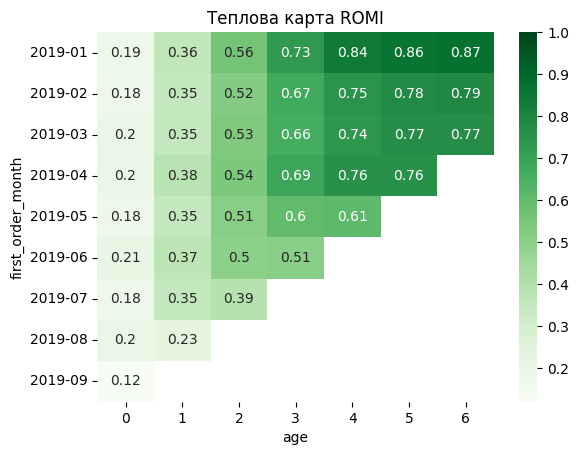

In [91]:
sns.heatmap(romi_report, cmap='Greens', annot=True,vmax=1)
plt.title('Теплова карта ROMI')
plt.show()

Реклама не окуповується навіть за 7 місяців.

In [55]:
romi_report.mean(axis=0)

age
0    0.184444
1    0.342500
2    0.507143
3    0.643333
4    0.740000
5    0.792500
6    0.810000
dtype: float64

В середньому на сьомоій місяць ми відбиваемо лише 81% вкладених коштів на залучення клієнта. А після сьмого місяця покупок по нашим даним немає. 

Розрахуємо максимальну ціну залучення клієнта для відділу маркетингу. Щоб він окупився за 6 місяців.

In [58]:
cohorts_pivot

age,0,1,2,3,4,5,6
first_order_month,,,,,,,
2019-01,536.09,486.79,567.30,484.43,325.30,70.30,4.99
2019-02,550.61,483.71,523.49,441.55,258.12,87.59,17.05
2019-03,625.21,493.26,549.31,425.31,246.65,89.21,4.13
2019-04,571.72,526.89,456.34,417.85,198.74,19.91,NaN
2019-05,538.12,506.77,449.91,259.60,31.19,NaN,NaN
2019-06,622.31,495.97,370.32,53.28,NaN,NaN,NaN
2019-07,534.98,514.04,121.04,NaN,NaN,NaN,NaN
2019-08,580.19,115.93,NaN,NaN,NaN,NaN,NaN
2019-09,381.30,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
 
max_cac = cohorts_pivot.cumsum(axis=1).mean(axis=0)[5].round(2)

cprint('------------------------------------------', 'red')
cprint(f'Максимальний CAC на 6 місяців: {max_cac} грн', 'green', attrs=['bold'])
cprint('------------------------------------------', 'red')

------------------------------------------
Максимальний CAC на 6 місяців: 2358.92 грн
------------------------------------------


# Висновок

Незважаючи та те, що з першого погляду справи в нашій компанії ніби йдуть добре по графіку з витратами та виручкою. Я можу говорити впевнено, що в перерахунку на чистий прибуток ми працюємо в мінус і нам потрібно шукати інші канали залучення клієнтів або оптимізувати бізнес модель для підвищення нашої маржинальності. При теперешній бізнес моделі ми не маємо перевищувати САС в 2358 грн. 

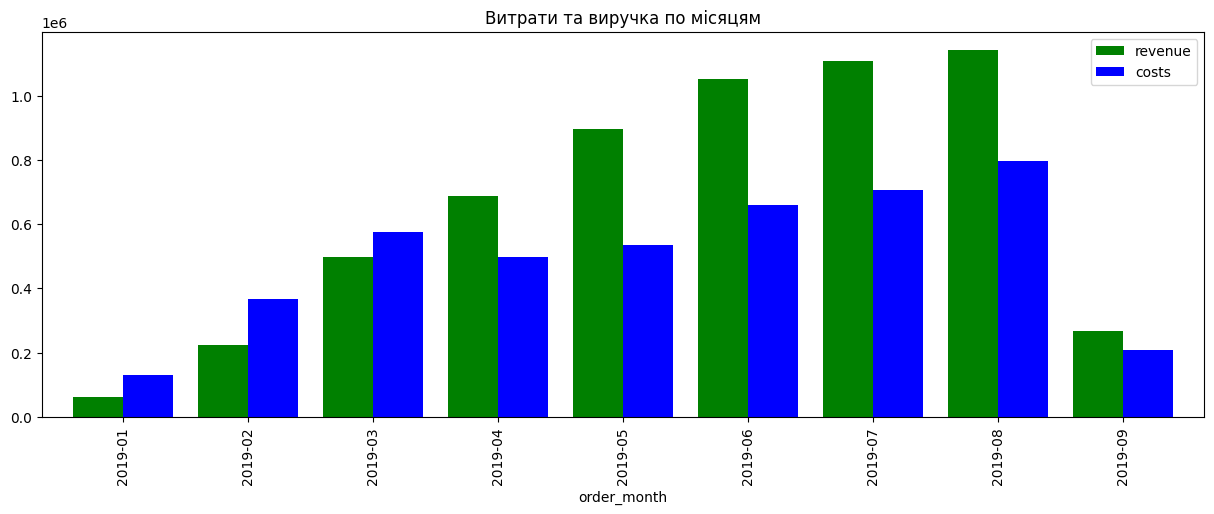

І ще я б звернув увагу на когорти які прийшли в останні місяці вони приносять ще меньше прибутку ніж перші когорти.

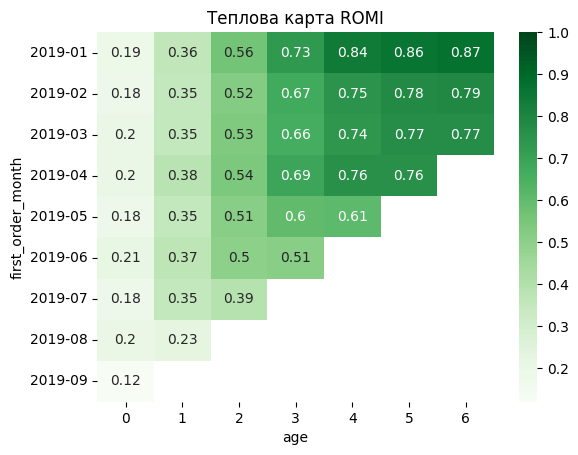